1. 删掉 ST
2. 删掉业绩亏损
3. 删掉净资产为负
4. 选取市盈率前 200 名
5. 选取市净率 200 名
6. MA-5 > MA - 21 且缺口变大 $\Rightarrow$ 可能会继续向上 || MA-21 > MA-5 且缺口变小 $\Rightarrow$ 可能会金叉

In [2]:
import tushare as ts
import numpy as np
import datetime
import loess
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as sm_ts_tools
from dateutil.relativedelta import relativedelta
import seaborn as sns

In [3]:
## Set up the date
today = '20' + datetime.date.today().strftime('%y%m%d')

In [4]:
index_all = ts.get_today_all()

df1 = index_all.copy()  #建立一个备份
n = 100  #选择前n个数据

[Getting data:]############################################################

In [5]:
df1['a']=[('ST' in x )for x in df1.name.astype(str)]  #先给ST股票做标记a
df1=df1.set_index('a')  #将a设置为索引 
df1=df1.drop(index=[True]) #删除ST股票
df1=df1.reset_index(drop=True) #重建默认索引

In [7]:
#删除业绩亏损的股票
df1 = df1[df1.per >0]

#删除净资产为负的股票
df1 = df1[df1.pb >0]

#选取市盈率前 200 名股票
df2 = df1.sort_values(by=['per'],ascending=True).head(n)
#print(len(df2))
#选取市净率 200 名股票
df3 = df1.sort_values(by=['pb'],ascending=True).head(n)
#print(len(df3))
#生成股票代码集合，进行集合运算
g2 = set(df2.code) #低市盈率股票代码
#print(len(g2))
g3 = set(df3.code) #低市净率股票代码
#print(len(g3))
g = g2&g3 #集合交运算
#print(len(g))
pending_list = list(g)  #把集合转为列表
print('Basic Selection:',pending_list, "Totally:", len(pending_list))

pending_list_csv = pd.DataFrame({"Code":pending_list})
pending_list_csv.to_csv("pending_list.csv")

Basic Selection: ['000732', '000980', '601288', '000040', '600019', '600919', '600016', '000900', '002092', '600623', '000959', '000926', '600348', '600000', '600823', '600022', '601818', '600657', '600997', '600708', '600123', '000898', '601169', '601699', '601328', '600569', '601166', '600376', '000791', '600782', '000402', '000825', '601988', '600015', '600971', '601998'] Totally: 36


In [7]:
# Comparing MA-5 & MA-21
# MA-5 ts.get_hist_data(pending_list[i])['close'].rolling(5).mean().shift(-4) 
# MA-21 ts.get_hist_data(pending_list[i])['close'].rolling(21).mean().shift(-20) 


# If MA-5 > MA-21, it is bullrish
# If MA-5 < MA-21, it is bearish

MA_5L_21 = []
MA_21L_5 = []

def MA(code, date):
    return ts.get_hist_data(code)['close'].rolling(date).mean().shift(-date + 1)

from tqdm import tqdm

stock_wanted = []
for i in tqdm(range(0, len(pending_list))):
    MA5_21 = (MA(pending_list[i],5) - MA(pending_list[i], 21)).to_frame()[0:5] 
    MA21_5 = (MA(pending_list[i],21) - MA(pending_list[i], 5)).to_frame()[0:5] 
    # if (dataframe['close'][3] == True) and (dataframe['close'][4] == True):
    if (MA5_21['close'][0] > MA5_21['close'][1]) and (MA5_21['close'][1] > MA5_21['close'][2]) and (MA5_21['close'][2] > MA5_21['close'][3]):
        print("MA(5) > MA(21)", pending_list[i])
        MA_5L_21.append(pending_list[i])
    if (MA21_5['close'][0] > MA21_5['close'][1]) and (MA21_5['close'][1] > MA21_5['close'][2]) and (MA21_5['close'][2] > MA21_5['close'][3]):
        print("MA(21) > MA(5)", pending_list[i])
        MA_21L_5.append(pending_list[i])
print(MA_5L_21)

  3%|▎         | 1/36 [00:00<00:29,  1.20it/s]

MA(21) > MA(5) 000900


  6%|▌         | 2/36 [00:01<00:28,  1.20it/s]

MA(21) > MA(5) 000980


  8%|▊         | 3/36 [00:02<00:27,  1.21it/s]

MA(21) > MA(5) 002092


 11%|█         | 4/36 [00:03<00:26,  1.21it/s]

MA(21) > MA(5) 600348


 14%|█▍        | 5/36 [00:04<00:26,  1.18it/s]

MA(21) > MA(5) 000898


 17%|█▋        | 6/36 [00:05<00:25,  1.19it/s]

MA(21) > MA(5) 600657


 19%|█▉        | 7/36 [00:05<00:24,  1.19it/s]

MA(21) > MA(5) 600971


 22%|██▏       | 8/36 [00:06<00:23,  1.20it/s]

MA(21) > MA(5) 000732


 25%|██▌       | 9/36 [00:07<00:22,  1.20it/s]

MA(21) > MA(5) 601288


 28%|██▊       | 10/36 [00:08<00:21,  1.20it/s]

MA(21) > MA(5) 601998


 31%|███       | 11/36 [00:09<00:20,  1.21it/s]

MA(21) > MA(5) 600623


 33%|███▎      | 12/36 [00:09<00:19,  1.21it/s]

MA(21) > MA(5) 600019


 36%|███▌      | 13/36 [00:10<00:19,  1.21it/s]

MA(21) > MA(5) 601328


 39%|███▉      | 14/36 [00:11<00:18,  1.20it/s]

MA(21) > MA(5) 600000


 42%|████▏     | 15/36 [00:12<00:17,  1.20it/s]

MA(21) > MA(5) 601818


 44%|████▍     | 16/36 [00:13<00:16,  1.21it/s]

MA(5) > MA(21) 000040


 47%|████▋     | 17/36 [00:14<00:15,  1.21it/s]

MA(21) > MA(5) 000959


 50%|█████     | 18/36 [00:15<00:15,  1.20it/s]

MA(21) > MA(5) 600919


 53%|█████▎    | 19/36 [00:15<00:14,  1.16it/s]

MA(21) > MA(5) 600376


 56%|█████▌    | 20/36 [00:16<00:13,  1.17it/s]

MA(21) > MA(5) 000926


 58%|█████▊    | 21/36 [00:17<00:12,  1.18it/s]

MA(21) > MA(5) 601988


 61%|██████    | 22/36 [00:18<00:11,  1.17it/s]

MA(21) > MA(5) 600569


 64%|██████▍   | 23/36 [00:19<00:10,  1.19it/s]

MA(21) > MA(5) 000402


 67%|██████▋   | 24/36 [00:20<00:10,  1.17it/s]

MA(21) > MA(5) 000825


 69%|██████▉   | 25/36 [00:20<00:09,  1.18it/s]

MA(21) > MA(5) 601169


 72%|███████▏  | 26/36 [00:21<00:08,  1.19it/s]

MA(21) > MA(5) 600782


 75%|███████▌  | 27/36 [00:22<00:07,  1.19it/s]

MA(21) > MA(5) 600016


 78%|███████▊  | 28/36 [00:23<00:06,  1.19it/s]

MA(21) > MA(5) 600708


 81%|████████  | 29/36 [00:24<00:05,  1.20it/s]

MA(21) > MA(5) 600997


 83%|████████▎ | 30/36 [00:25<00:04,  1.21it/s]

MA(21) > MA(5) 600823


 86%|████████▌ | 31/36 [00:25<00:04,  1.20it/s]

MA(21) > MA(5) 600123


 89%|████████▉ | 32/36 [00:26<00:03,  1.19it/s]

MA(21) > MA(5) 000791


 92%|█████████▏| 33/36 [00:27<00:02,  1.20it/s]

MA(21) > MA(5) 601699


 94%|█████████▍| 34/36 [00:28<00:01,  1.19it/s]

MA(21) > MA(5) 600015


 97%|█████████▋| 35/36 [00:29<00:00,  1.20it/s]

MA(21) > MA(5) 600022


100%|██████████| 36/36 [00:30<00:00,  1.19it/s]

MA(21) > MA(5) 601166
['000040']


In [8]:
print(MA_5L_21)
print(MA_21L_5)

['000040']
['000900', '000980', '002092', '600348', '000898', '600657', '600971', '000732', '601288', '601998', '600623', '600019', '601328', '600000', '601818', '000959', '600919', '600376', '000926', '601988', '600569', '000402', '000825', '601169', '600782', '600016', '600708', '600997', '600823', '600123', '000791', '601699', '600015', '600022', '601166']


## Locally Weighted Scatter Plot

局部加权回归散点平滑法

In [9]:
def lowess_plot(code_list, time_length):
    while time_length <= 15:
        return print("The prediction is unauthentic, use a longer time period")
    
    for i in range(0, len(code_list)):
        code = code_list[i]
        data = ts.get_hist_data(code).reset_index()

        data.head()

        data_open = np.array(data['open'])
        data_close = np.flipud(np.array(data['close']))
        data_date = np.array(data['date'])
        data_volume = np.array(data['volume'])

        x = range(0, time_length)
        y = data_close[0:time_length]
        y_1 = data_open[0:time_length]
        y_2 = data_volume[0:time_length]
        
        # lowess will return our "smoothed" data with a y value for at every x-value
        lowess = sm.nonparametric.lowess(y, x, frac= 0.3)
        lowess_x = list(zip(*lowess))[0]
        lowess_y = list(zip(*lowess))[1]


        # run scipy's interpolation. There is also extrapolation I believe
        f = interp1d(np.flipud(lowess_x), np.flipud(lowess_y), bounds_error=False)

        xnew = [i/10. for i in range(400)]

        # this this generate y values for our xvalues by our interpolator
        # it will MISS values outsite of the x window (less than 3, greater than 33)
        # There might be a better approach, but you can run a for loop
        #and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
        ynew = f(xnew)

        print("The prediction is not the reality, just for fun!")
        plt.title(code_list[i]+ "Local Regression Simulation")
        plt.plot(x, y, 'o')
        plt.plot(lowess_x, lowess_y, color = "red")
        plt.show()

How low you want to predict: 100
The prediction is not the reality, just for fun!


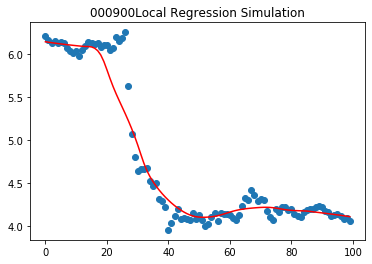

The prediction is not the reality, just for fun!


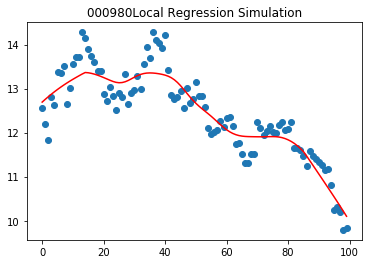

The prediction is not the reality, just for fun!


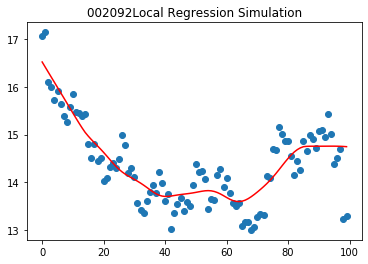

The prediction is not the reality, just for fun!


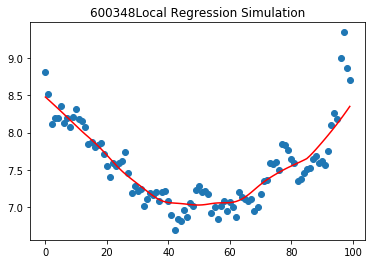

The prediction is not the reality, just for fun!


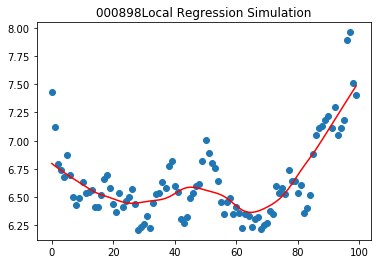

The prediction is not the reality, just for fun!


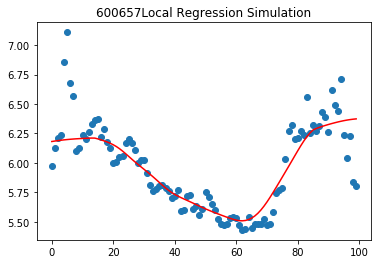

The prediction is not the reality, just for fun!


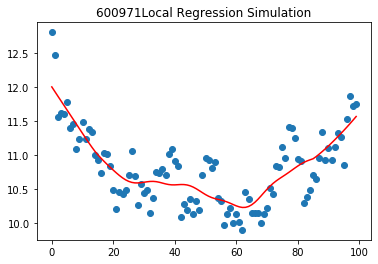

The prediction is not the reality, just for fun!


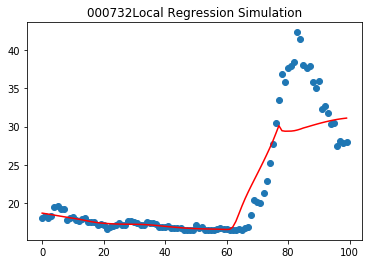

The prediction is not the reality, just for fun!


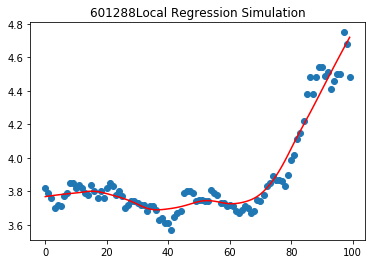

The prediction is not the reality, just for fun!


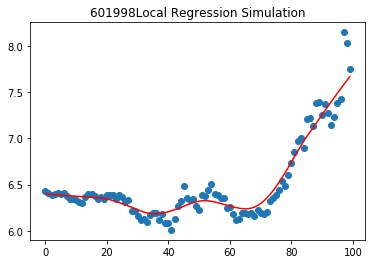

The prediction is not the reality, just for fun!


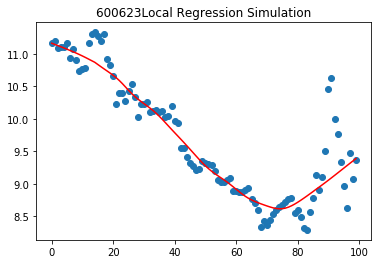

The prediction is not the reality, just for fun!


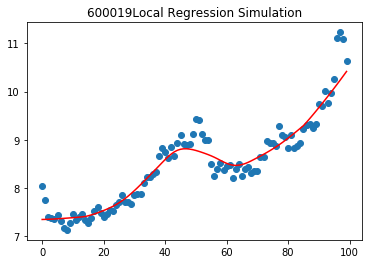

The prediction is not the reality, just for fun!


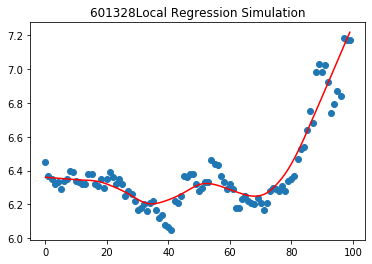

The prediction is not the reality, just for fun!


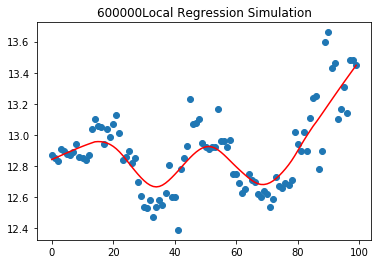

The prediction is not the reality, just for fun!


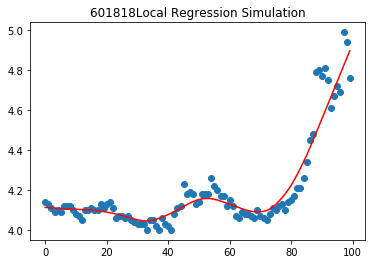

The prediction is not the reality, just for fun!


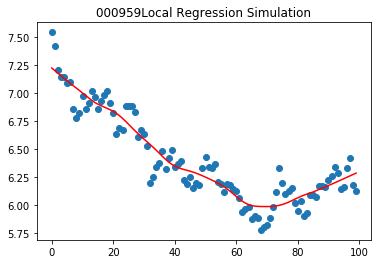

The prediction is not the reality, just for fun!


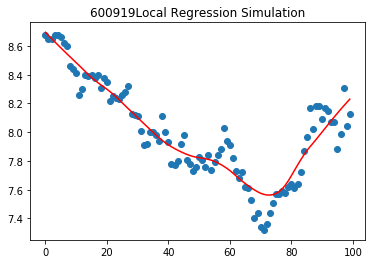

The prediction is not the reality, just for fun!


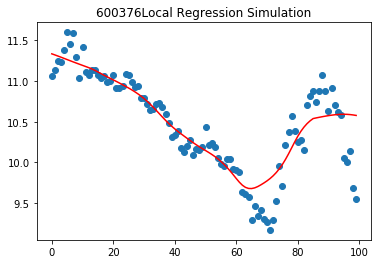

The prediction is not the reality, just for fun!


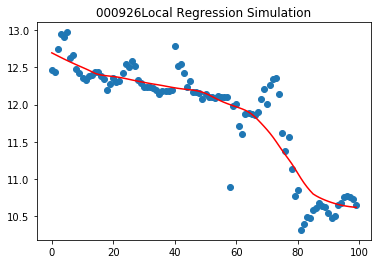

The prediction is not the reality, just for fun!


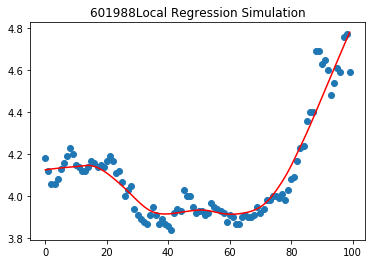

The prediction is not the reality, just for fun!


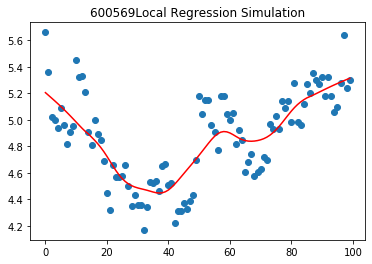

The prediction is not the reality, just for fun!


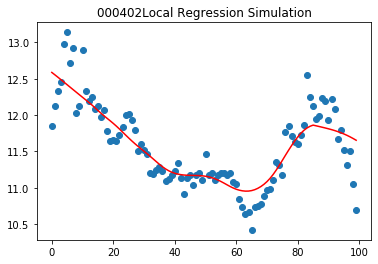

The prediction is not the reality, just for fun!


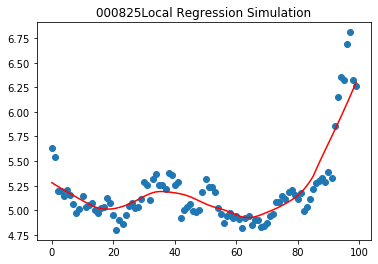

The prediction is not the reality, just for fun!


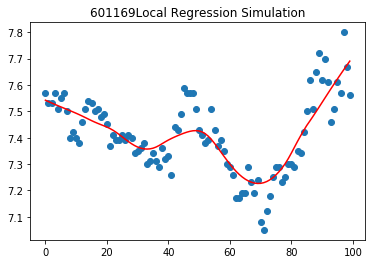

The prediction is not the reality, just for fun!


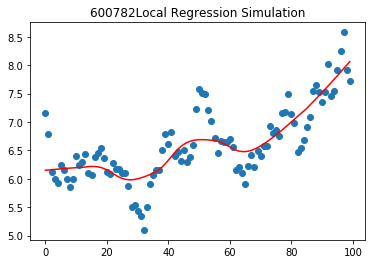

The prediction is not the reality, just for fun!


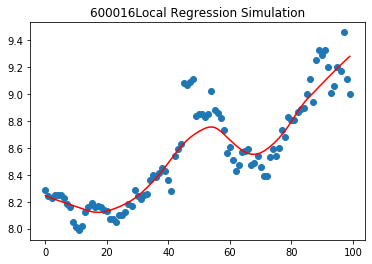

The prediction is not the reality, just for fun!


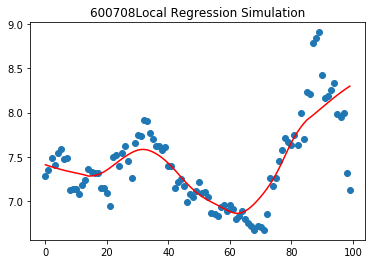

The prediction is not the reality, just for fun!


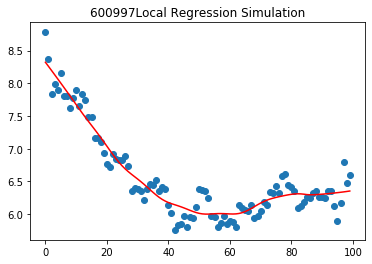

The prediction is not the reality, just for fun!


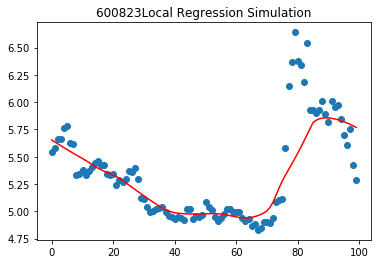

The prediction is not the reality, just for fun!


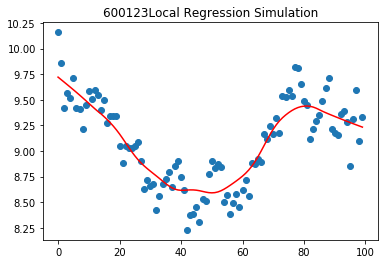

The prediction is not the reality, just for fun!


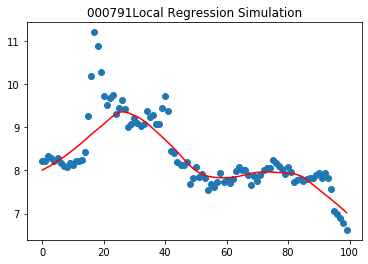

The prediction is not the reality, just for fun!


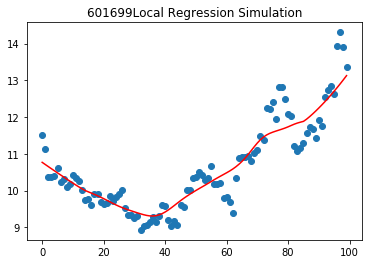

The prediction is not the reality, just for fun!


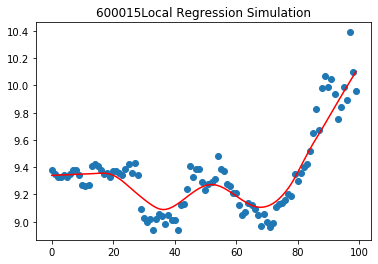

The prediction is not the reality, just for fun!


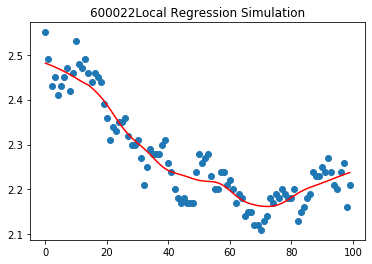

The prediction is not the reality, just for fun!


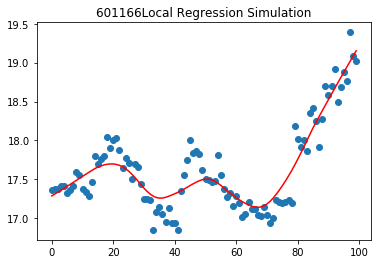

In [10]:
time_length = input("How low you want to predict: ") 
lowess_plot(MA_21L_5, int(time_length))